# Assingment #1

## Part1 Rendering a Lambertian sphere

We want to create a picture of a shaded sphere like in the lecture slides, which means we need to first define a spherical surface. Let us assume that it has a radius of r=60.

You can now define the surface as a parametrization of z-values using z= z(x,y), which determines the points that satisfy the condition of being a sphere.

The full set of points on the surface is easily defined using np.linspace then! Please take only one hemisphere (the positive one).

According to the cosine-law, the intensity at each point is the dot-product of the normal of the surface with the lighting direction.

The normal n=[nx,ny,nz] is the cross-product of the partial derivatives of the sphere parametrization with respect to x and y and is given by $[n_x=-\frac{\partial z(x,y)}{\partial x}, n_y=-\frac{\partial z(x,y)}{\partial y}, n_1]$!. Calculate these derivatives BY HAND by deriving the function z and insert them into your code. Do not forget to normalize the vector!

Using the illumination direction of I = (0.15,0,0.94), calculate the shaded sphere and insert code to plot the final result.

Tip: You may need to mask out pixels if you plot a larger region!


### Set up

In [1]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from math import cos 
import numpy as np
# %matplotlib inline
%matplotlib notebook

### Calculate n derivatives

$z=\sqrt{r^2-x^2-y^2}$

$n=[\frac{\partial z(x,y)}{\partial x}, \frac{\partial z(x,y)}{\partial y}, 1]$

$\frac{\partial z(x,y)}{\partial x}=\frac{\sqrt{r^2-x^2-y^2}}{\partial x} \rightarrow \frac{\partial \sqrt{f}}{\partial x}=\frac{\frac{\partial f}{\partial x}}{2\sqrt{f}} \rightarrow \frac{\frac{z^2-x^2-y^2}{\partial x}}{2\sqrt{r^2-x^2-y^2}}=-\frac{2x}{2\sqrt{r^2-x^2-y^2}}=-\frac{x}{z}$

$(\because f=r^2-x^2-y^2,\frac{\partial \sqrt f}{\partial x} = \frac{\partial \sqrt f}{\partial f}\cdot\frac{\partial f}{\partial x}=\frac{1}{2\sqrt{f}}\cdot\frac{\partial f}{\partial x})$

$\frac{\partial z(x,y)}{\partial y}=-\frac{y}{z}$

$\therefore n=[-\frac{x}{z}, \frac{y}{z}, 1]$

- normal shape from shading

$E(x,y)=R_{\rho,I}(p,q)=\rho \overrightarrow{I}^T \overrightarrow{n}=\frac{\rho}{\sqrt{1+p^2+q^2}}\overrightarrow{I}^T[-p,-q,1]^T$

### Calculate $x, y, z, E(x,y)$

In [2]:
# define radius, center of sphere
r = 60
x_0, y_0, z_0 = [0, 0, 0]

# define diffuse albedo, illumination direction
k = 1 
I = np.array([0.15, 0, 0.94])

# Calculate the range of x, y, z
u = np.linspace(0, 2 * np.pi, 1000)
v = np.linspace(0, 0.5 * np.pi, 250)
x = r * np.outer(np.cos(u), np.sin(v)) + x_0
y = r * np.outer(np.sin(u), np.sin(v)) + y_0
z = r * np.outer(np.ones(np.size(u)), np.cos(v)) + z_0

# Calculate the nx, ny, nz
nx = -np.divide(x, z).flatten()
ny = -np.divide(y, z).flatten()
nz = np.ones(nx.shape)

norm_factor = np.sqrt(nx**2+ny**2+nz**2)

# normal shape from shading
R = k/norm_factor*np.dot(I, np.array([nx, ny, nz]))
R = np.divide(R-np.min(R), np.max(R)-np.min(R))
R = np.array(R, dtype=str)

### Visualization 2D

<IPython.core.display.Javascript object>


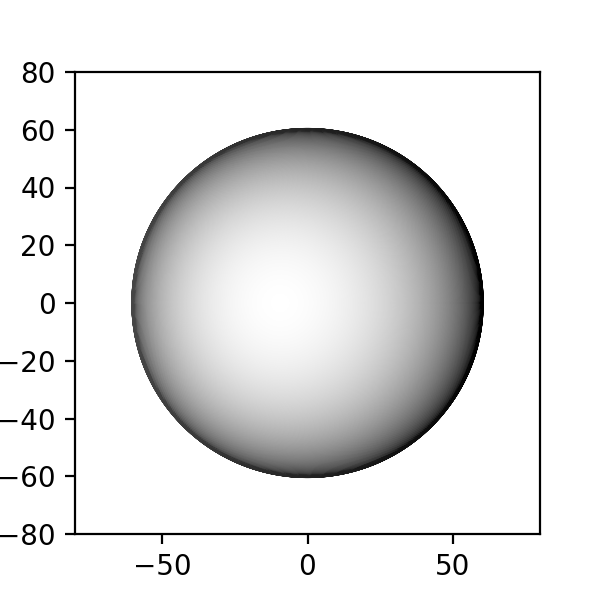

In [3]:
plt.figure(figsize=(3,3))
plt.style.use('grayscale')
plt.xlim(-80,80)
plt.ylim(-80,80)
plt.scatter(x, y, c=R, s=0.1)
plt.show()

### Visualization 3D

<IPython.core.display.Javascript object>


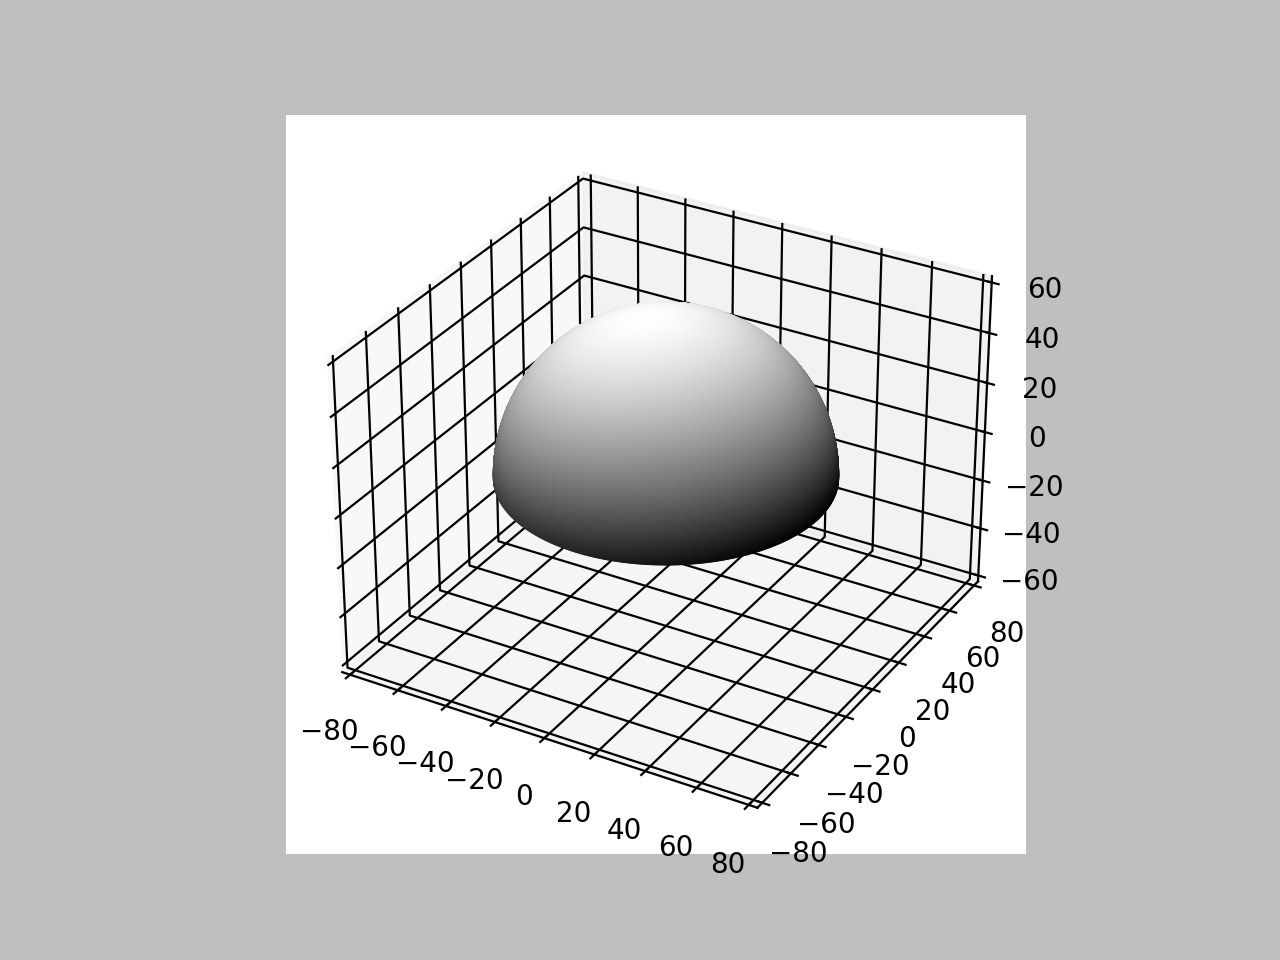

In [4]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

plt.style.use('grayscale')
ax.set_xlim(-80,80)
ax.set_ylim(-80,80)
ax.set_zlim(-60,60)
ax.scatter(x, y, z, c=R, s=0.1)
plt.show()

## Bonus

Bonus (10 points): Insert code that creates an animation with a moving light source that moves around the sphere [in any way you like]!

In [20]:
from ipywidgets import IntSlider, interact, FloatSlider
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm
import imageio
from PIL import Image
import cv2
import sys
import os
from os.path import isfile, join
import warnings
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})
mpl.get_backend()

'module://ipykernel.pylab.backend_inline'

In [12]:
def calc_R(r, I, k=1, coord=[0,0,0]):
    """
    Calculate the x, y, z, R
    
    Argument
    --------
    r: radius (int)
    I: illumination direction (numpy array)
    k: diffuse albedo (float)
    coord: center of sphere (list)
    
    """
    u = np.linspace(0, 2 * np.pi, 1000)
    v = np.linspace(0, 0.5 * np.pi, 250)
    x = r * np.outer(np.cos(u), np.sin(v)) + coord[0]
    y = r * np.outer(np.sin(u), np.sin(v)) + coord[1]
    z = r * np.outer(np.ones(np.size(u)), np.cos(v)) + coord[2]

    nx = -np.divide(x, z).flatten()
    ny = -np.divide(y, z).flatten()
    nz = np.ones(nx.shape)

    norm_factor = np.sqrt(nx**2+ny**2+nz**2)
    
    R = k/norm_factor*np.dot(I, np.array([nx, ny, nz]))
    R = np.divide(R-np.min(R), np.max(R)-np.min(R))
    R = np.array(R, dtype=str)
    
    return x, y, z, R

### Animation 2D

In [13]:
r = 60
x_0, y_0, z_0 = [0, 0, 0]
k = 1

eps = np.finfo(np.float32).eps.item() # Smallest number such that 0.0 + eps != 0.0
Ix = np.linspace(eps, 1, 100)
Iy = np.linspace(1, eps, 100)
Iz = np.linspace(0.5, 1, 100)

plt.style.use('grayscale')
image_path = './image/2d/'

# create image path if it doesn't exist
if not os.path.exists(image_path):
        os.makedirs(image_path)
else:
    print(image_path + " has been processed!")

for i in tqdm(range(len(Ix))):
    plt.figure(figsize=(4,4))
    plt.xlim(-80,80)
    plt.ylim(-80,80)
    plt.axis('off')
    
    I = np.array([Ix[i], Iy[i], Iz[i]])
    x, y, z, R = calc_R(r, I)
    
    plt.scatter(x, y, c=R, s=0.1)
    
    # save the pictures
    plt.savefig(image_path+'sphere2d_{}.png'.format(str(i).zfill(3)))
    plt.close()

./image/2d/ has been processed!


In [8]:
# Load image file list
frame_array = []
files = [f for f in os.listdir(image_path) if isfile(join(image_path, f))]
files.sort()

gif_path = './gif'

# create gif path if it doesn't exist
if not os.path.exists(gif_path):
        os.makedirs(gif_path)
else:
    pass  

# create a gif file
images = [ Image.open(image_path + i) for i in files]
imageio.mimsave('{}/{}'.format(gif_path, 'sphere2d.gif'), images, fps=20)

<img src='./gif/sphere2d.gif' width='400'>

### Animation 3D

In [9]:
x_0, y_0, z_0 = [0, 0, 0]
k = 1
eps = np.finfo(np.float32).eps.item()
Ix = np.linspace(eps, 1, 100)
Iy = np.linspace(1, eps, 100)
Iz = np.linspace(0.5, 1, 100)

plt.style.use('grayscale')
image_path = './image/3d/'

# create image path if it doesn't exist
if not os.path.exists(image_path):
        os.makedirs(image_path)
else:
    pass

for i in tqdm(range(len(Ix))):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(-80,80)
    ax.set_ylim(-80,80)
    ax.set_zlim(-60,60)
    ax.set_axis_off()
    
    I = [Ix[i], Iy[i], Iz[i]]

    x, y, z, R = calc_R(r, I)
    
    ax.scatter(x, y, z, c=R, s=1)
    
    # save the pictures
    plt.savefig(image_path+'sphere3d_{}.png'.format(str(i).zfill(3)))
    plt.close()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [10]:
frame_array = []
files = [f for f in os.listdir(image_path) if isfile(join(image_path, f))]
files.sort()

gif_path = './gif'

# create gif path if it doesn't exist
if not os.path.exists(gif_path):
        os.makedirs(gif_path)
else:
    pass  

# create a gif file
images = [ Image.open(image_path + i) for i in files]
imageio.mimsave('{}/{}'.format(gif_path, 'sphere3d.gif'), images, fps=20)

<img src='./gif/sphere3d.gif' width='600'>

### Slider

In [32]:
def draw_sphere(r, Ix, Iy, Iz):
    """
    Draw sphere
    
    Argument
    --------
    r: radius (int)
    Ix: x of illumination direction 
    Iy: y of illumination direction 
    Iz: z of illumination direction 

    """

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')

    plt.style.use('grayscale')
    ax.set_xlim(-80,80)
    ax.set_ylim(-80,80)
    ax.set_zlim(-60,60)
    
    I = [Ix, Iy, Iz]
    x, y, z, R = calc_R(r, I)
    ax.scatter(x, y, z, c=R, s=0.1)
    plt.show()


In [34]:
x_slider = FloatSlider(value=0.1, min=0.1, max=1, step=0.1)
y_slider = FloatSlider(value=0.1, min=0.1, max=1, step=0.1)
z_slider = FloatSlider(value=0.1, min=0.1, max=1, step=0.1)
r_slider = IntSlider(value=60, min=10, max=100, step=10)

print('It takes time for the image to change.')

interact(draw_sphere, 
         r=r_slider,
         Ix=x_slider,
         Iy=y_slider,
         Iz=z_slider,
)

It takes time for the image to change.


interactive(children=(IntSlider(value=60, description='r', min=10, step=10), FloatSlider(value=0.1, descriptio…

<function __main__.draw_sphere(r, Ix, Iy, Iz)>

-------